<a href="https://colab.research.google.com/github/pokablive/class-jyouhoushori/blob/main/ae_ipynb_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Encoder

AE; Auto Encoder, 自己符号化器

![](https://cdn-ak.f.st-hatena.com/images/fotolife/n/nkdkccmbr/20161006/20161006215630.png)  
オートエンコーダのイメージ  
出典：[オートエンコーダ-- ニューラルネットワーク・DeepLearningなどの画像素材　プレゼン・ゼミなどに【WTFPL】](https://nkdkccmbr.hateblo.jp/entry/2016/10/06/222245)

In [1]:
! pip install skorch

In [2]:
# packageのimport
import math
from datetime import datetime
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.auto import trange,tqdm
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use("bmh")
from sklearn.manifold import TSNE

# pytorch関連のimport
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import skorch
from skorch import NeuralNet, NeuralNetClassifier, NeuralNetRegressor

# animation
from matplotlib.animation import ArtistAnimation
from IPython.display import display, Markdown, HTML

/Users/sasakiyuto/miniforge3/envs/class/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("pytorch ver.:",torch.__version__)
print("numpy ver.:",np.__version__)
print("Apple Siliconが使える:", torch.backends.mps.is_available())
print("CUDAが使える:", torch.cuda.is_available())
!python -VV

pytorch ver.: 2.0.0
numpy ver.: 1.24.3
Apple Siliconが使える: True
CUDAが使える: False
Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]


## Auto Encoderとは

このノートにおける __AutoEncoder__（以降 __AE__）{cite:ps}`Hinton2006-yj`とは，ニューラル自己符号化器と呼ばれるものを指します．私たちは単にこれをAEと呼び，入力されたデータベクトル（テンソル）を，より次元の小さいベクトルに圧縮した後に，そのベクトルを使って元のデータを再構築するようなニューラルネットワークを指します．

例えば28x28x1の画像データは，flattenすると784個の要素があることがわかりますね．これを50次元のベクトルに圧縮するニューラルネットワークを用意し，更に圧縮表現から元の784要素に戻すニューラルネットワークを作るのが今回の試みです．個別のネットワークとしてもいいですし，一気通貫に圧縮と展開を担うニューラルネットワークを作っても良いでしょう．このようにデータを圧縮するネットワーク（モジュール）を __Encoder（エンコーダー）__ ，圧縮されたベクトルを元にデータを再構築するのを __Decoder（デコーダー）__ と呼びます．

また，Encoderはデータ点を元あった空間から潜在的な変数空間へマップする作業をしていると考えられるので，圧縮されたベクトルを __潜在ベクトル__ などと呼ぶこともあります．

> ![](https://camo.qiitausercontent.com/fa16c4be587b9e9b61e9c803c683f0ffafcf8690/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3135353631392f39336638316537642d663766612d396138382d383636372d3538646231666330316330332e706e67)  
出典：[AutoEncoder, VAE, CVAEの比較　〜なぜVAEは連続的な画像を生成できるのか？〜 - Qiita](https://qiita.com/kenchin110100/items/7ceb5b8e8b21c551d69a )

このようにあるデータを，元の次元数より小さい次元数のベクトルなどに圧縮する技術のことを，__次元削減（Dimensionality reduction, dimension reduction）__ と呼びます．

:::{note}  
:class: dropdown

圧縮という言葉が出てきたので，圧縮方法の二つの大別について紹介しておきます．


__可逆圧縮（ロスレス圧縮）__ : 圧縮ファイルを展開すると元のファイルを完全に復元することができます．
- zip
- rar
- 7zip

__不可逆圧縮__ : : 圧縮ファイルを展開しても元のファイルを完全に復元することができませんが，一般に圧縮率が高いのが特徴です．
- jpg
- mp3
- mp4

:::



## AutoEncoderのアーキテクチャと実装

### 最もシンプルなAE

#### 実装

最も簡単なAEの構成は，全結合層と適切な活性化関数を用いて，特徴数→圧縮次元数→特徴数の順に変換する三層のニューラルネットワークです．  
ここでは入力されるデータベクトルの各要素が0~1の範囲の値であるとして考えていきます．そのため，出力層の活性化関数はSigmoidにしてあります．また，pytorchにおいて画像データは一枚一枚が[チャネル, 縦, 横]の配列で表現されるので，バッチごとにデータを入力するならば[バッチサイズ, チャネル, 縦, 横]の配列になります．これを入力層からデータを入れるときには，これまでのMLPを思い出せば[バッチサイズ, チャネル$\times$ 縦 $\times$ 横]の配列にreshapeする必要がありそうです．

この前提でネットワークを組むと以下のようになります．

In [4]:
class SimpleAE(nn.Module):
    def __init__(self, in_features:int, n_components:int):
        super().__init__()
        self.in_features = in_features
        self.n_components = n_components
        # build layers
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.n_components),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.n_components, self.in_features),
            nn.Sigmoid(),
        )

    def forward(self, x:torch.Tensor):
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

ae = SimpleAE(10,2)
display(ae)

SimpleAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
  )
)

わかりやすいように，Encoder部分とDecoder部分をそれぞれnn.Sequentialインスタンスとしています．また，このモデルの損失関数には再構成誤差を用います．ここでは具体例として二乗和誤差を使うことにします．

#### チューニング

この構成で良い結果が得られない場合は以下のことを検討すると良いでしょう．

1. バッチノーマライゼーションの追加
2. 活性化関数を変更
3. より深層化
4. 正則化項の追加

### Weight Tying/ Weight Sharing

#### Weight Tyingを使った線形変換レイヤの実装

「最もシンプルなAE」から更に，パラメータ数を減らしてみましょう．ここで使うのが __Weight Tying__ や __Weight Sharing__ と呼ばれるテクニックです．これはいくつかのレイヤーで結合重みを共有するというアプローチです．膨大な特徴量を受け取るようなnn.Linearクラスの重みを使い回すことでメモリを節約できます．ここではEncoderの全結合層とDecoderの全結合層の結合重みを共有します．

In [5]:
class WeightTyingLinear(nn.Module):
    """ほぼnn.Linearと同じで，結合重みだけ別のnn.Linearインスタンスを利用するクラス"""
    def __init__(self, shared_weights:torch.Tensor,bias:bool=True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()

        self.weight = shared_weights.T
        self.out_features,self.in_features = self.weight.size()
        if bias:
            self.bias = nn.Parameter(torch.empty((self.out_features), **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

#### 重みの受け取りとbiasの初期化

コンストラクタでshared_weightsとしてencoder側の重みを受け取り，これを使ってforwardメソッドで全結合層の処理を行います．biasは共有できない（encoderとdecoderではshapeが違います）ので，コンストラクタの中で初期化しています．
- nn.Parameterクラス
    - nn.Moduleのコンストラクタで学習可能パラメータを用意するためのクラスです．
- reset_parametersメソッド
    - nn.Linearから借用したメソッドです．self.biasはとりあえずtorch.emptyで初期化してありますが，これはモダンなbiasの初期化方法ではないのでreset_parametersメソッドで改めて初期化を行っています．
    - 具体的にはHeの初期化{cite}`He2015-rc` を行います．

#### extra_reprメソッド

extra_reprメソッドには「このクラスのインスタンスを直接printしたときに表示したい文字列」を返り値として設定してあげます．今回の実装だと例えば：
```
WeightTyingLinear(in_features=2, out_features=10, bias=True)
```
のような表示がされるはずです．今回は[nn.Linearクラスの実装](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)を参考にしているので，自作レイヤを作る際には公式実装を読んで書き方を掴んでください．


::::{admonition} extra_reprメソッドとその周辺
:class: tip
:class: dropdown

extra_reprメソッドは，nn.Moduleサブクラスのインスタンスをprintした際に表示される文字列を設定するメソッドです．\__str\__や\__repr\__のように一般的なPythonクラスに用意された特殊メソッドではなく，nn.Module独自のメソッドになります．

- `extra_repr`メソッド
    - クラスの名前や内部のパラメータの形状などを出力させます．
- `__str__`メソッド
    - 人間にとってわかりやすく，画面に表示しやすいオブジェクトの表現を出力させます．（した方がいいです）
- `__repr__`メソッド
    - eval関数で評価すると元のオブジェクトに戻るような，Pythonが元のオブジェクトを復元できるオブジェクト表現を出力させます．（した方がいいです）

何の設定もしていない自作クラスがどのように表示されるかを見てみましょう：  

In[]
```python
class temp:
    ...

obj = temp()

print("普通にprintした時に表示されるもの:\t",obj)
print("オブジェクトのid:\t\t\t",id(obj))
print("オブジェクトのidを16進数にしたもの:\t", hex(id(obj)))
```
Out[]
```
普通にprintした時に表示されるもの:	 <__main__.temp object at 0x104e7b370>
オブジェクトのid:			 4377260912
オブジェクトのidを16進数にしたもの:	 0x104e7b370
```

特に何の設定もしていない自作クラスをprintすると，オブジェクトのid（識別子）が16進数で表示されるようです．また，おそらく皆さんはCPythonを利用しているはずなので，このオブジェクトidにはメモリアドレスが利用されています．

```
>>> id?
Signature: id(obj, /)
Docstring:
Return the identity of an object.

This is guaranteed to be unique among simultaneously existing objects.
(CPython uses the object's memory address.)
Type:      builtin_function_or_method`
```

ただし，id関数のdocstringには  
> これは同時に存在するオブジェクトの中で一意であることが保証されています。(CPythonはオブジェクトのメモリアドレスを使います)。

と書かれているだけなので，逆説的に，CPython以外のPython実装では，オブジェクトidがメモリアドレスだとは限らないことに注意です．

::::

#### Auto Encoderクラスの実装

AEクラスは前述のものとほぼ同じです．

In [6]:
class WeightTyingAE(nn.Module):
    def __init__(self, in_features:int, n_components:int):
        super().__init__()
        self.in_features = in_features
        self.n_components = n_components
        # build layers
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.n_components),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            WeightTyingLinear(self.encoder[0].weight),
            nn.Sigmoid(),
        )

    def forward(self, x:torch.Tensor):
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)

本当にパラメータ共有ができているのかチェックしてみましょう．

In [7]:
ae2 = WeightTyingAE(10,2)
display(ae2)
print("パラメータが共有されているのかをチェック：")
for ix, params in enumerate(ae2.parameters()):
    print("--"*30)
    print(f">>> params_{ix}:")
    print(params)
    print(params.shape)

WeightTyingAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): WeightTyingLinear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
  )
)

パラメータが共有されているのかをチェック：
------------------------------------------------------------
>>> params_0:
Parameter containing:
tensor([[-0.5121,  0.2254,  0.2371, -0.3775, -0.1436, -0.5366, -0.6161,  0.0915,
         -0.1183, -0.2092],
        [-0.1322,  0.6922, -0.4579,  0.3749,  0.3511, -0.4215,  0.0939, -0.2502,
         -0.1018,  0.4514]], requires_grad=True)
torch.Size([2, 10])
------------------------------------------------------------
>>> params_1:
Parameter containing:
tensor([-0.2553,  0.0495], requires_grad=True)
torch.Size([2])
------------------------------------------------------------
>>> params_2:
Parameter containing:
tensor([ 0.6992, -0.3836,  0.3247,  0.3536, -0.2765,  0.6237, -0.7030, -0.2348,
        -0.6467,  0.3510], requires_grad=True)
torch.Size([10])


パラメータは4つの配列のはずが，この実装ではWeight Tyingによって一つ削減できていることがわかります．

### 画像の形状を変えずにネットワーククラスに入力する

入力データの配列をできるだけそのまま（配列の形状を変更せずに[バッチサイズ, チャネル, 縦, 横]のまま）入力することを考えてみましょう．[バッチサイズ, チャネル, 縦, 横]を[バッチサイズ, チャネル$\times$ 縦 $\times$ 横]へ変形するための機能は，通常の行列計算ライブラリならflatten関数/メソッドかviewメソッド，またはreshapeメソッドで提供されています．

In [8]:
a = torch.zeros([3,1,2,2])
print("配列aの形状：", a.shape)
print("a=", a)

print("---"*20)
print("flattenメソッド:")
a1 = a.flatten(start_dim=1)
print("flattenを適用した配列aの形状：", a1.shape)
print("a=",a1)

print("---"*20)
print("viewメソッド:")
a2 = a.view((a.shape[0], -1))
print("viewを適用した配列aの形状：", a2.shape)
print("a=",a2)

print("---"*20)
print("reshapeメソッド:")
a3 = a.reshape((a.shape[0], -1))
print("reshapeを適用した配列aの形状：", a3.shape)
print("a=",a3)

配列aの形状： torch.Size([3, 1, 2, 2])
a= tensor([[[[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]]]])
------------------------------------------------------------
flattenメソッド:
flattenを適用した配列aの形状： torch.Size([3, 4])
a= tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
------------------------------------------------------------
viewメソッド:
viewを適用した配列aの形状： torch.Size([3, 4])
a= tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
------------------------------------------------------------
reshapeメソッド:
reshapeを適用した配列aの形状： torch.Size([3, 4])
a= tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


これらのメソッドのどれかをネットワーククラスのforwardクラスの最初に入力配列に対して適用し，出力層の出力をreshapeで入力配列と同じ形状に直すことで，ネットワークの外側で配列の形状を変える必要がなくなります．

ただし，nn.Sequentialの中に並べるには，nn.Moduleのサブクラスである必要があります．flattenはnn.Flattenというクラスがあるのでこれを使えばいいのですが，Reshapeは対応するクラスがありません．

:::{note}
:class: dropdown

「nn.Sequentialの中に並べるには，nn.Moduleのサブクラスである必要があります．」  
例えばnn.Sigmoidの代わりにF.sigmoidをnn.Sequentialに渡した場合：
```python
nn.Sequential(
    nn.Linear(10,20),
    F.sigmoid
    )
```
以下のエラーが発生：
```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[384], line 1
----> 1 nn.Sequential(
      2     nn.Linear(10,20),
      3     F.sigmoid
      4     )

File ~/.pyenv/versions/miniforge3-4.10.3-10/envs/datasci/lib/python3.10/site-packages/torch/nn/modules/container.py:104, in Sequential.__init__(self, *args)
    102 else:
    103     for idx, module in enumerate(args):
--> 104         self.add_module(str(idx), module)

File ~/.pyenv/versions/miniforge3-4.10.3-10/envs/datasci/lib/python3.10/site-packages/torch/nn/modules/module.py:596, in Module.add_module(self, name, module)
    586 r"""Adds a child module to the current module.
    587
    588 The module can be accessed as an attribute using the given name.
   (...)
    593     module (Module): child module to be added to the module.
    594 """
    595 if not isinstance(module, Module) and module is not None:
--> 596     raise TypeError("{} is not a Module subclass".format(
    597         torch.typename(module)))
    598 elif not isinstance(name, str):
    599     raise TypeError("module name should be a string. Got {}".format(
    600         torch.typename(name)))

TypeError: torch.nn.functional.sigmoid is not a Module subclass
```

:::

こういうときには，nn.Moduleを継承したサブクラスを作成し，その中でreshapeに相当する関数を使うことになります．例えば以下のような形になります：


```python
class Reshape(nn.Module):
    def __init__(self, img_shape:tuple[int]) -> None:
        super().__init__()
        self.img_shape = img_shape

    def forward(self,x:torch.Tensor)->torch.Tensor:
        return x.view((x.shape[0], *self.img_shape))
    
    def extra_repr(self) -> str:
        return 'in_features={}, out_img_shape={}'.format(
            np.prod(self.img_shape),self.img_shape,
        )
    
class SimpleAE(nn.Module):
    def __init__(self, img_shape:tuple[int], n_components:int):
        super().__init__()
        self.img_shape = img_shape
        self.in_features = np.prod(img_shape)
        self.n_components = n_components
        # build layers
        self.encoder = nn.Sequential(
            nn.Flatten(), # diff (batch_size, 1, 28, 28)->(batch_size, 1x28x28)
            nn.Linear(self.in_features, self.n_components),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.n_components, self.in_features),
            nn.Sigmoid(),
            Reshape(self.img_shape) # diff (batch_size, 1x28x28)->(batch_size, 1, 28, 28)
        )

    def forward(self, x:torch.Tensor):
        h = self.encoder(x)
        return h, self.decoder(h)
```



## 実験

MNISTデータセット{cite}`Bottou94`を圧縮する実験を行います．また，今回は訓練の進み具合を確認するために，1 epochごとに事前に選んでおいた画像を再構成させてみます．

### データの準備

skorchを使う場合はtraining/validation splitをskorchがやってくれるので，自分で行う必要がありません．また，DataLoaderの用意もskorchが行うので準備不要です．datasetだけ用意しておきましょう．

In [9]:
def load_MNIST_skorch():
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    train_set = torchvision.datasets.MNIST(root="./data",
                                           train=True,
                                           download=True,
                                           transform=transform)

    test_set = torchvision.datasets.MNIST(root="./data",
                                         train=False,
                                         download=True,
                                         transform=transform)
    return {"train":train_set, "test": test_set}

::::{admonition} skorchを使わない場合
:class: dropdown

skorchを使わない場合は以下のようにMNISTのデータローダを用意しておきます．関数はCNNのところで使ったものと同じです．
```python
def load_MNIST(batch=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
        #transforms.Lambda(lambda x: torch.flatten(x))
        ])

    train_set = torchvision.datasets.MNIST(root="./data",
                                           train=True,
                                           download=True,
                                           transform=transform)
    # train_validation_split.
    # see also https://qiita.com/takurooo/items/ba8c509eaab080e2752c#%E8%A7%A3%E6%B1%BA%E7%AD%962-torchutilsdatarandom_split.
    n_samples = len(train_set) # n_samples is 60000
    train_size = int(len(train_set) * 0.8) # train_size is 48000
    val_size = n_samples - train_size # val_size is 48000
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch,
                                               shuffle=True,
                                               num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set,
                                               batch_size=batch,
                                               shuffle=True,
                                               num_workers=2)
    

    test_set = torchvision.datasets.MNIST(root="./data",
                                         train=False,
                                         download=True,
                                         transform=transform)
    test_loader =torch.utils.data.DataLoader(test_set,
                                            batch_size=batch,
                                            shuffle=True,
                                            num_workers=2)

    return {"train":train_loader, "validation":val_loader, "test": test_loader}
```
::::

一応中身を確認しておきましょう．

/var/folders/ck/c_p4lsds5kzb7y1mk5zh6c0w0000gn/T/ipykernel_11074/157737928.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


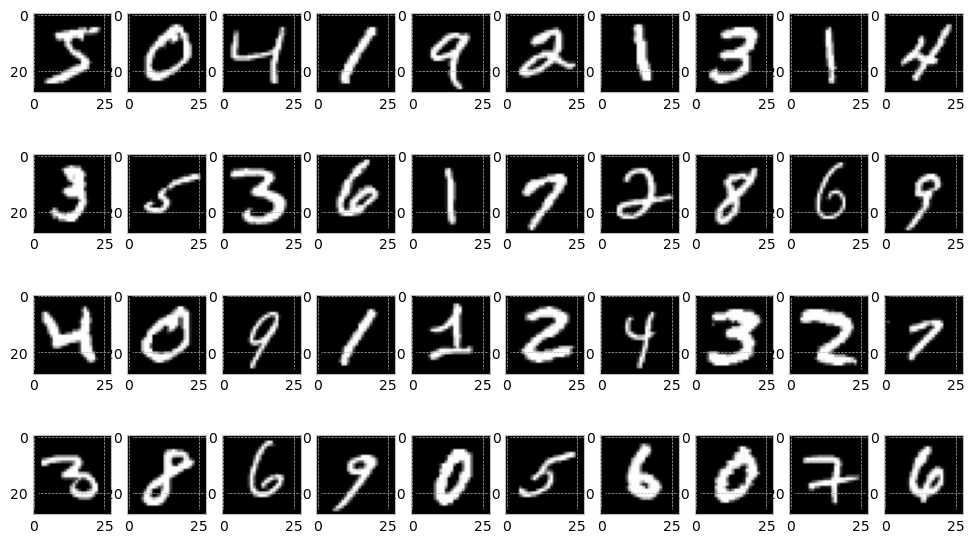

In [10]:
# 中身を確認しておく．今回は適当に40個取り出してみます．
_dataset = load_MNIST_skorch()
_train_dataset= _dataset["train"]

fig = plt.figure(figsize=[12,7])
for ix, batch in enumerate(_train_dataset):
    img,y = batch
    ax = fig.add_subplot(4,10,ix+1)
    ax.imshow(img.view(-1,28), cmap='gray')
    if ix == 39:
        break
fig.show()

### 訓練

学習スクリプトもskorchに任せることにします．ただし，skorchはクラス分類や回帰用のクラスを用意してくれていますが，AutoEncoder向けのものがないので回帰のもの少し修正して利用します．

In [11]:
class NeuralNetAE(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        encoded, decoded = y_pred
        recons_loss = super().get_loss(decoded, kwargs["X"], *args, **kwargs)
        return recons_loss

y_trueにはfitでyとして渡されたものが入るので，学習データがtensor or arrayでXという変数に入っている場合は`trainer.fit(X,X)`とすることもできます．この場合は
```python
recons_loss = super().get_loss(decoded, y_true, *args, **kwargs)
```
とすればいいでしょう．今回は画像データセットを利用するので，全てのデータをXとして持てるか不安なので前述のコードにしてあります．ただし，入力されるXと再構成したいXが異なる場合（入力Xにノイズが入っていて，そこから綺麗なXを再構成したい場合など）は今の書き方は使えないかもしれません．この場合，forwardの中でノイズ付与を行うことになりますが，タスクによっては諦めてtrainer.fit(X,X)を使いましょう．

ハイパーパラメータの定義：

In [12]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 20
LEARNING_RATE = 0.01
MAX_EPOCHS = 50
BATCH_SIZE = 128

再構成した画像を保存しておくためのコールバック：

1. 最初に0~9の画像を一枚ずつ選んでインスタンス変数として持っておく．
2. epochごとに画像を再構成させる．
3. 再構成画像をインスタンス変数として保持しておく．

In [13]:
class ReconsImage(skorch.callbacks.Callback):
    @staticmethod
    def get_sample():
        """0~9の数字の手書き文字画像をランダムに一枚ずつ適当に選ぶ"""
        transform = transforms.Compose([
            transforms.ToTensor(),])
        test_set = torchvision.datasets.MNIST(root="./data",
                                            train=False,
                                            download=True,
                                            transform=transform)
        sample = []
        i = 0
        for x,y in iter(test_set):
            if y == i:
                sample.append(x)
                i+=1
            if len(sample) == 10:
                break
        return sample

    def initialize(self):
        """最初に一度だけ呼ばれる"""
        self.sample_imgs = self.get_sample()
        self.fig_anime = plt.figure(figsize=[15,5])
        self.axs = []
        for i in range(20):
            self.axs.append(self.fig_anime.add_subplot(2,10,i+1))

        self.frames = []

    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs)->None:
        """epoch終了時に毎回呼ばれる"""
        net.module_.eval()
        frame = []
        with torch.no_grad():
            for i in range(10):
                art1 = self.axs[i].imshow(self.sample_imgs[i].view(-1,28).detach().cpu().numpy(),
                            cmap='gray')
                _, sample_hat = net.module_(self.sample_imgs[i].view([1,-1]).to(net.device))
                frame.append(art1)
                art2 = self.axs[i+10].imshow(sample_hat.view(-1,28).detach().cpu().numpy(),
                                cmap="gray")
                frame.append(art2)
        self.frames.append(frame)

    def on_train_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        """学習終了時に一回だけ呼ばれる"""
        plt.close(self.fig_anime)

trainerの用意と訓練メソッドのキック

In [14]:
recons_image = ReconsImage()

trainer = NeuralNetAE(
    # models
    SimpleAE(28**2, LATENT_DIM),
    optimizer= optim.Adam,
    criterion = nn.MSELoss,

    # hyper-params
    lr = LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    device = DEVICE,
    train_split=skorch.dataset.ValidSplit(5), # 0.2 を valid setとして利用

    # callbacks
    callbacks=[("recons_image", recons_image)]
)
# prepare datasets
dataset = load_MNIST_skorch()
train_dataset = dataset["train"]
y_train = np.array([y for x, y in iter(train_dataset)]) # y_trainはダミーです．np.zeros(len(train_dataset))でもOK．

# training start!
trainer.fit(train_dataset, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0668        0.0629  3.3717
      2        0.0620        0.0619  3.6966
      3        0.0587        0.0573  3.2815
      4        0.0547        0.0532  3.3283
      5        0.0528        0.0529  4.4236
      6        0.0515        0.0506  4.3173
      7        0.0494        0.0498  3.6315
      8        0.0472        0.0462  3.5821
      9        0.0436        0.0425  3.9995
     10        0.0416        0.0418  4.0950
     11        0.0410        0.0415  3.9670
     12        0.0396        0.0393  3.9544
     13        0.0384        0.0384  4.0461
     14        0.0380        0.0381  4.3028
     15        0.0378        0.0379  3.5223
     16        0.0375        0.0370  3.6748
     17        0.0362        0.0359  4.3133
     18        0.0356        0.0356  4.1449
     19        0.0353        0.0354  4.1330
     20        0.0352        0.0353  4.3622
     21        0.0351        0.0

<class '__main__.NeuralNetAE'>[initialized](
  module_=SimpleAE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=20, bias=True)
      (1): Sigmoid()
    )
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=784, bias=True)
      (1): Sigmoid()
    )
  ),
)

::::{admonition} skorchを使わない場合の訓練スクリプト
:class: dropdown

```python
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 20
LEARNING_RATE = 0.01
MAX_EPOCHS = 50
BATCH_SIZE = 128
data_loader = load_MNIST(batch=BATCH_SIZE)
model = SimpleAE(np.prod(img.size()), LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


#学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": [],
    "frames": [],
}

"""学習過程の可視化"""
# 訓練中に利用する画像を用意しておく
sample_imgs = get_sample()

# プロットの雛形を用意しておく
fig_anime = plt.figure(figsize=[15,5])
axs = []
for i in range(20):
    axs.append(fig_anime.add_subplot(2,10,i+1))
"""/学習過程の可視化"""

for epoch in trange(MAX_EPOCHS):
    # training step
    loss = None
    train_loss = 0.0
    model.train()
    for i,(x,y) in enumerate(data_loader["train"]):
        x,y = x.to(DEVICE),y.to(DEVICE)
        x = x.view(x.shape[0], -1)
        # 勾配の初期化
        optimizer.zero_grad()
        # 順伝搬 -> 逆伝搬 -> 最適化
        x_hat = model(x)
        loss = criterion(x_hat, x)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader["train"])
    history["train_loss"].append(float(train_loss))

    """validation step"""
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x,y in data_loader["validation"]:
            x,y = x.to(DEVICE),y.to(DEVICE)
            x = x.view(x.shape[0], -1)
            x_hat = model(x)
            val_loss = criterion(x_hat,x)

    val_loss /= len(data_loader["validation"])
    #print("Validation loss: {}\n".format(val_loss))
    history["validation_loss"].append(float(val_loss))
    
    """学習過程の可視化"""
    model.eval()
    with torch.no_grad():
        history["frames"].append([])
        for i in range(10):
            art1 = axs[i].imshow(sample_imgs[i].view(-1,28).detach().cpu().numpy(),
                          cmap='gray')
            sample_hat = model(sample_imgs[i].view([1,-1]).to(DEVICE))
            history["frames"][-1].append(art1)
            art2 = axs[i+10].imshow(sample_hat.view(-1,28).detach().cpu().numpy(),
                             cmap="gray")
            history["frames"][-1].append(art2)
    """/学習過程の可視化"""
    
plt.close(fig_anime) # 余計な図を表示させないようにする
```

::::

損失関数の可視化

これでAEの訓練が完了したはずです．もちろんmax_epochsやlearning rateのようなハイパーパラメータの設定をより良いものに変えることで，もっと良いものにできる可能性はあります．興味があれば試してみてください．

### 訓練過程のモニタリング

##### 損失関数のモニタリング

損失関数の値の変化を見ると，40エポックを過ぎたあたりで値が収束し始めていることがわかります．

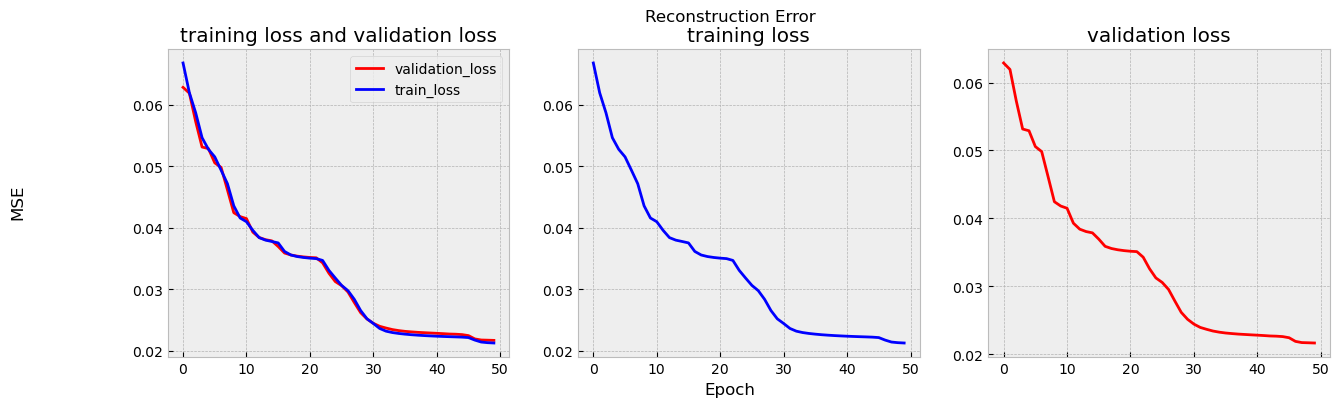

In [15]:
def plot_loss(history, save_path=None):
    fig = plt.figure(figsize=[15,4])
    fig.suptitle("Reconstruction Error")
    fig.supxlabel("Epoch")
    fig.supylabel("MSE")

    ax = fig.add_subplot(1,3,1)
    ax.set_title("training loss and validation loss")
    ax.plot(history[:,"valid_loss"], label="validation_loss", color="red")
    ax.plot(history[:,"train_loss"], label="train_loss", color="blue")
    ax.legend()


    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title("training loss")
    ax2.plot(history[:,"train_loss"], label="train_loss", color="blue")

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title("validation loss")
    ax3.plot(history[:,"valid_loss"], label="validation_loss", color="red")

    if save_path is not None:
        fig.savefig(save_path)
    plt.close()
    return fig

fig = plot_loss(trainer.history)
display(fig)

::::{admonition} skorchを利用しない場合
:class: dropdown

```python
def plot_loss(history, save_path=None):
    fig = plt.figure(figsize=[15,4])
    fig.suptitle("Reconstruction Error")
    fig.supxlabel("Epoch")
    fig.supylabel("MSE")

    ax = fig.add_subplot(1,3,1)
    ax.set_title("training loss and validation loss")
    ax.plot(history["validation_loss"], label="validation_loss", color="red")
    ax.plot(history["train_loss"], label="train_loss", color="blue")
    ax.legend()


    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title("training loss")
    ax2.plot(history["train_loss"], label="train_loss", color="blue")

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title("validation loss")
    ax3.plot(history["validation_loss"], label="validation_loss", color="red")

    if save_path is not None:
        fig.savefig(save_path)
    plt.close()
    return fig

fig = plot_loss(history)
display(fig)
```

#### 再構築画像のモニタリング

訓練を重ねるごと（epochごと）に，AEがどれだけ上手く画像を再現できるようになったのかを確認してみましょう．上の学習がうまくいった方は，既に表示されているアニメーションを確認してください．また，以下に事前に訓練を行った際に作成したアニメーションを示しました．これらから，AEが徐々に上手く画像の再構成ができるようになっていることがわかると思います．

In [16]:
with open("./figs/ae/autoencoder_mnist.html", "r") as f:
    anim_html = f.read()

display(HTML(anim_html))
display(Markdown("アニメーション①：「AEの学習の様子」．（上段：オリジナルの画像，下段：再構築した画像．シークバーを進めるとepochが進みます．"))

FileNotFoundError: [Errno 2] No such file or directory: './figs/ae/autoencoder_mnist.html'

上記のアニメーションは以下のコードで作成できます．

In [ ]:
anim = ArtistAnimation(recons_image.fig_anime, recons_image.frames, interval=150)
dt_now = datetime.now().strftime('%Y年%m月%d日%H時%M分%S秒')
#anim.save(f"autoencoder_mnist-{dt_now}.gif") # 今回は実験終了時間をファイル名に含めることにします．
#with open(f"autoencoder_mnist-{dt_now}.html", "w") as f:
#    f.write(anim.to_jshtml())

display(HTML(anim.to_jshtml()))

### 潜在空間の可視化

今回作ったAEでは，Encoder側出力は入力された画像を20次元の潜在的空間の点として表現しています．潜在空間上でどのように画像が点として描かれるのかを見るには，20次元だと可視化することが難しいので，どうにかして2次元の潜在空間上の点になるようにする必要があります．しかしながら，LATENT_DIM=2に設定して再訓練してもうまく行きません．

例として，LATENT_DIM=2として訓練したAEを使い，テストデータを散布図として表示してみることにします．
![](figs/ae/ae_mnist_2d_scatter.png)

テストデータの画像はクラスごとに何かしらの特徴を持っているはずなので，潜在空間の中でもある程度はクラスごとにグルーピングされていると嬉しいはずです．しかしながら上の散布図は全くの不規則に散らばっているように見えます．これは潜在空間の次元数が2だけだと，AEの学習がうまくいっていないことを示しています．

学習がうまくいっていないことを確認するために，画像の再構成結果を示します．

![](./figs/ae/ae_2d_recons.png)

20次元の時とは異なり，まったく再現できていないことが分かりました．AEで直接2次元に圧縮するのは（このままだと）難しいようです．

そこでここでは，可視化のための時限削減アルゴリズムであるt-SNE{cite}`Van_der_Maaten2008-jw`を利用して，以下の条件で作成した画像を見比べることで「潜在空間がどれだけ重要な情報を残せているのか」をチェックしてみます．
1. 画像をそのままt-SNEで2次元に圧縮して作成した散布図
2. 画像をAEで2次元に圧縮した後に，t-SNEで2次元に圧縮して作成した散布図
3. 画像をAEで20次元に圧縮した後に，t-SNEで2次元に圧縮して作成した散布図

::::{admonition} t-SNEを使った散布図の作成
:class: dropdown

step 1: 全てのテストデータを潜在表現に変換します．

```python
def transform(model:SimpleAE, dataloader:DataLoader)->dict:
    model.eval()
    embedded_matrix = []
    X_test = []
    labels = []
    device = "cuda:0" if next(model.parameters()).is_cuda else "cpu"
    for batch in dataloader:
        x,y = batch
        x = x.to(device)
        z = model.encoder(x.view(x.shape[0],-1))
        embedded_matrix.append(z.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())
        X_test.append(x.view(x.shape[0],-1).detach().cpu().numpy())
    embedded_matrix = np.vstack(embedded_matrix)
    labels = np.hstack(labels)
    X_test = np.vstack(X_test)
    return {"埋め込みベクトル": embedded_matrix,
            "labels": labels,
            }

model = trainer.module_
output = transform(model, data_loader["test"])
```

step2: TSNEを使って2次元に圧縮します．

```python
tsne = TSNE()
E = tsne.fit_transform(output["埋め込みベクトル"])
```

step3: matplotlibを使って2次元散布図を作成します．

```python
FILE_PATH = "./figs/ae/ae20_tsne_mnist_2d_scatter"
FIG_TITLE = "Scatter plot of MNIST based on AutoEncoder"

fig_2d = plt.figure(figsize=[10,10])
fig_2d.suptitle(FIG_TITLE)
ax = fig_2d.add_subplot()
for label in sorted(set(output["labels"])):
    mask = output["labels"] == label
    ax.scatter(E[:,0][mask], E[:,1][mask], label=label)
    ax.set_xlabel("component 1")
    ax.set_ylabel("component 2")
    ax.legend()

fig_2d.savefig(FILE_PATH)
fig_2d.show()
```

::::

::::{tab-set}
:::{tab-item} 1の画像
![](./figs/ae/tsne_mnist_2d_scatter.png)

（１）TSNEで元のデータセットを2次元散布図にした所，クラスごとにグループになって表示されていることがわかります．
:::

:::{tab-item} 2の画像
![](./figs/ae/ae2_tsne_mnist_2d_scatter.png)

（２）AEで2次元にした後にTSNEにかけたものは，クラスごとにまとまった様子はありません．
:::

:::{tab-item} 3の画像
![](./figs/ae/ae20_tsne_mnist_2d_scatter.png)

（３）AEで20次元にした後にTSNEにかけたものは，（１）と同じようにクラスごとにグループになって表示されているようです．
:::

::::

2次元空間はあくまでも相対的なものなので，クラスごとの位置関係が（１）と（３）で変わっていることには目を瞑ってください．ここから分かることは，クラスに関する何かしらの情報を（１）と（３）は保持しているのに対して，（２）はそれが欠落しているということです．AEでは際限なく小さな次元にデータを圧縮できるわけではなく，圧縮率を上げると情報が落ちすぎて無意味になる場合があることを覚えておきましょう．



## 参考文献

```{bibliography}
:filter: docname in docnames
```